# Attention

There are problems where fully connected neural nets and CNNs are not suitable. One of the examples is dealing with sequences of different lengths.

In this notebook, we will see how Self-Attention can solve the sorting problem. Given an rbitrary length sequence of digits, the task is to return sorted one.

```
Input:  [1 1 1 8 4 6 8 5 8 2 6]
Output: [1 1 1 2 4 5 6 6 8 8 8]
```

Let's implement the problem using a generator.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Attention, Input, Dense, LayerNormalization, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
one_hot = np.eye(10)

def pad(list_of_seq):
    N = max([len(seq) for seq in list_of_seq])
    return np.stack([np.pad(seq, (0, N - len(seq)))
                     for seq in list_of_seq])

def generator(max_seq_len, batch_size=32):
    while True:
        X = [np.random.randint(10, size=np.random.randint(max_seq_len))
             for _ in range(batch_size)]
        y = [np.sort(x) for x in X]
        yield one_hot[pad(X)], one_hot[pad(y)]

Now we can take a look at a small batch.

In [3]:
gen = generator(12, batch_size=5)
X, y = next(gen)
for inp, out in zip(X, y):
    print('\nInput: ', inp.argmax(axis=1))
    print('Output:', out.argmax(axis=1))


Input:  [7 9 4 0 0 0 0 0 0 0 0]
Output: [4 7 9 0 0 0 0 0 0 0 0]

Input:  [4 2 0 0 0 0 0 0 0 0 0]
Output: [0 2 4 0 0 0 0 0 0 0 0]

Input:  [0 8 7 3 8 0 4 5 8 3 3]
Output: [0 0 3 3 3 4 5 7 8 8 8]

Input:  [5 7 0 5 1 0 5 0 0 0 0]
Output: [0 0 1 5 5 5 7 0 0 0 0]

Input:  [4 6 3 6 0 0 0 0 0 0 0]
Output: [3 4 6 6 0 0 0 0 0 0 0]


Note, that due to the padding this problem becomes even harder since 0 has different interpretations depending on where it is located. It is a good idea to pad with -1's instead, but let's stick with the current implementation to make it more challenging for the model.

## Self-Attention

In principle idea of self-attention is quite simple. Input vector gets multiplied by three matrixes - $Q, K, V$ to form **Q**uery, **K**ey and **V**alue vectors. Then **Q**uery and **K**ey are combined between the sequences to get weights which are then used to weight **V**alues before summing them up.

![Attention](img/self_attention.gif)

There are a lot of good explanations online if you want to go deeper and understand the math behind it - https://peterbloem.nl/blog/transformers.

## Transformer Block

To use self-attention effectively we need to harness a couple of tricks. The first is to mix it up with fully connected layers and introduce some skip connections.

![Transformer Block](img/transformer_block.png)

Since it is possible to repeat Transformer Blocks let's a for loop (for now it will be executed only once).

In [4]:
def build_model(hidden=32, num_heads=16, num_blocks=1):

    inp = Input((None, 10))
    emb = Dense(hidden)(inp)

    for _ in range(num_blocks):
        enc = MultiHeadAttention(num_heads=num_heads, key_dim=hidden)(emb, emb)
        enc = LayerNormalization(epsilon=1e-5)(enc + emb)

        fcn = Dense(hidden * 4, activation='relu')(enc)
        fcn = Dense(hidden)(fcn)
        emb = LayerNormalization(epsilon=1e-5)(fcn + enc)

    out = Dense(10, activation='softmax')(emb)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model

Let's define a helper function that plots sequences and an image and prints out a small sample.

In [5]:
def eval_model(model, gen, seq_to_print=5):
    X, y = next(gen)
    pred = model(X).numpy().argmax(axis=-1)
    real = y.argmax(axis=-1)
    plt.subplot(121)
    plt.imshow(pred)
    plt.axis('off')
    plt.title('Prediction')
    plt.subplot(122)
    plt.imshow(real)
    plt.axis('off')
    plt.title('Actual seq')
    plt.show()
    for p, a in zip(pred[:seq_to_print],
                    real[:seq_to_print]):
        print('\nPrediction:', p)
        print('Actual seq:', a)

Finally we are ready to train a model.

Metal device set to: Apple M1


2022-08-22 21:47:15.419906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-22 21:47:15.420010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-22 21:47:15.990242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-22 21:47:15.991041: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-08-22 21:47:16.233765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 8s 36ms/step - loss: 1.1721
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 1.0920
Epoch 3/10
200/200 [==============================] - 8s 38ms/step - loss: 1.0749
Epoch 4/10
200/200 [==============================] - 8s 39ms/step - loss: 1.0552
Epoch 5/10
200/200 [==============================] - 8s 39ms/step - loss: 1.0364
Epoch 6/10
200/200 [==============================] - 8s 38ms/step - loss: 1.0297
Epoch 7/10
200/200 [==============================] - 8s 38ms/step - loss: 1.0499
Epoch 8/10
200/200 [==============================] - 8s 38ms/step - loss: 1.0398
Epoch 9/10
200/200 [==============================] - 7s 37ms/step - loss: 1.0212
Epoch 10/10
200/200 [==============================] - 8s 38ms/step - loss: 1.0447


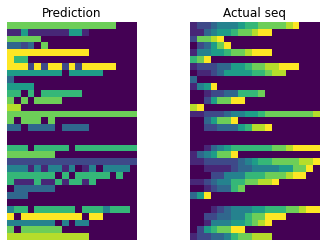


Prediction: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0]
Actual seq: [1 2 2 3 4 4 4 5 6 6 7 7 7 7 8 9 0 0 0]

Prediction: [1 1 5 1 1 1 1 1 1 5 5 1 0 0 0 0 0 0 0]
Actual seq: [1 1 3 4 5 5 6 7 7 8 9 9 0 0 0 0 0 0 0]

Prediction: [7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 7 7 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [3 3 2 3 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [0 2 3 5 7 9 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0]
Actual seq: [1 4 4 5 5 6 7 7 8 9 9 9 0 0 0 0 0 0 0]


In [6]:
gen = generator(max_seq_len=20)

model = build_model()
model.fit(gen, steps_per_epoch=200, epochs=10)

eval_model(model, gen)

At this point, the model can learn to deal with sequence length and can pick the element that is most common but fails with sorting problem... Clearly, we lack something that allows the model to learn sequential nature.

## Positional Embeddings

To resolve the problem we will add random weights for each position! We fix those *positional embeddings* before generating sequences and then add them to the inputs. The code below should be self-explanatory. 

In [7]:
def positional_generator(max_seq_len):
    positional_embedding = np.random.random((max_seq_len, 10))
    gen = generator(max_seq_len)
    while True:
        X, y = next(gen)
        N = y.shape[1]
        X += positional_embedding[:N]
        yield X, y

Let's retrain the model using updated generator.

Epoch 1/10
  1/200 [..............................] - ETA: 1:21 - loss: 2.2106

2022-08-22 21:48:32.104336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 8s 37ms/step - loss: 1.1802
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 0.8474
Epoch 3/10
200/200 [==============================] - 7s 36ms/step - loss: 0.7291
Epoch 4/10
200/200 [==============================] - 7s 36ms/step - loss: 0.6720
Epoch 5/10
200/200 [==============================] - 7s 37ms/step - loss: 0.6303
Epoch 6/10
200/200 [==============================] - 7s 36ms/step - loss: 0.5987
Epoch 7/10
200/200 [==============================] - 7s 36ms/step - loss: 0.5833
Epoch 8/10
200/200 [==============================] - 7s 37ms/step - loss: 0.5571
Epoch 9/10
200/200 [==============================] - 7s 37ms/step - loss: 0.5374
Epoch 10/10
200/200 [==============================] - 8s 38ms/step - loss: 0.5235


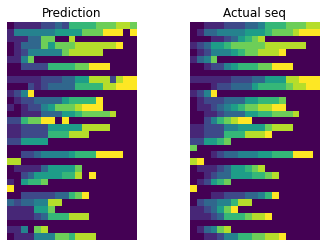


Prediction: [0 1 1 1 1 2 2 3 2 6 6 6 6 7 7 7 8 8 7]
Actual seq: [0 0 1 1 1 2 2 2 3 3 4 6 6 6 7 7 7 8 8]

Prediction: [1 4 4 4 4 4 4 5 5 5 5 7 7 7 9 9 9 0 9]
Actual seq: [0 1 3 3 4 4 4 4 5 5 5 6 7 7 7 8 9 9 9]

Prediction: [1 1 1 3 3 7 7 0 0 8 0 0 0 0 0 0 0 0 0]
Actual seq: [0 0 0 1 1 2 3 5 6 7 8 0 0 0 0 0 0 0 0]

Prediction: [0 1 3 3 3 7 5 7 7 7 8 8 8 8 8 8 9 0 0]
Actual seq: [1 2 3 5 5 6 7 7 7 7 7 8 8 8 8 8 8 0 0]

Prediction: [0 1 2 4 4 4 4 4 7 8 8 8 8 8 0 0 0 0 0]
Actual seq: [0 1 2 4 4 4 5 6 7 7 8 8 8 9 0 0 0 0 0]


In [8]:
gen = positional_generator(max_seq_len=20)

model = build_model()
model.fit(gen, steps_per_epoch=200, epochs=10)

eval_model(model, gen)

Much better! You can try to remove the attention layer to convince yourself that this net will fail without it.

## Final Architecture

For sure we can add more layers to get more power. It's already implemented above, we just need to pass `num_blocks=3` when constructing the model.

![Transformer Block](img/transformer.png)

Epoch 1/10


2022-08-22 21:49:46.419997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 20s 94ms/step - loss: 1.0445
Epoch 2/10
200/200 [==============================] - 19s 94ms/step - loss: 0.5815
Epoch 3/10
200/200 [==============================] - 19s 93ms/step - loss: 0.4544
Epoch 4/10
200/200 [==============================] - 19s 93ms/step - loss: 0.3942
Epoch 5/10
200/200 [==============================] - 19s 94ms/step - loss: 0.3435
Epoch 6/10
200/200 [==============================] - 19s 94ms/step - loss: 0.3268
Epoch 7/10
200/200 [==============================] - 19s 94ms/step - loss: 0.2976
Epoch 8/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2707
Epoch 9/10
200/200 [==============================] - 19s 96ms/step - loss: 0.2787
Epoch 10/10
200/200 [==============================] - 19s 97ms/step - loss: 0.2496


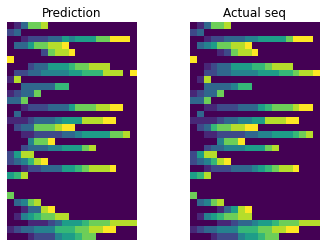


Prediction: [0 1 3 7 7 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [0 1 3 7 7 8 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [0 0 1 2 2 2 3 3 5 4 5 5 5 7 7 9 9 9 0]
Actual seq: [0 0 1 2 2 3 3 3 4 4 5 5 5 5 7 9 9 9 0]

Prediction: [0 3 3 5 7 7 8 8 9 0 0 0 0 0 0 0 0 0 0]
Actual seq: [0 3 4 5 7 7 8 8 9 0 0 0 0 0 0 0 0 0 0]

Prediction: [0 0 0 0 0 2 7 8 8 9 0 0 0 0 0 0 0 0 0]
Actual seq: [0 0 0 0 1 2 7 8 8 9 0 0 0 0 0 0 0 0 0]


In [9]:
gen = positional_generator(max_seq_len=20)

model = build_model(num_blocks=3)
model.fit(gen, steps_per_epoch=200, epochs=10)

eval_model(model, gen)

Training is still quite fast and this time results are nearly perfect. From time to time model messes up with zeros, but that is expected as discussed in the problem formulation.

## Age of Transformers

Attention is widely used for language and is finding its way into language, voice, vision, and basically any field that uses sequences or can be expressed as a sequence. It was popularized with a paper named [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Usually similarly to autoencoders, there is a block that encodes input data followed by a decoder. It can be from the same domain, for example as in translation problems, but even more interestingly it can be different domains, for example, encoding text and then decoding it as an image!

Widely known [GPT-3](https://openai.com/api/) used Transformers with attention to creating stunning text completions that can seam intelligent. It is common to see attention used in summarization, [translation](https://www.deepl.com/translator), and text classification solutions. [DALL-E 2](https://openai.com/dall-e-2/) as well as [midjourney](https://www.midjourney.com/showcase/) used them to create stunning art from the text descriptions.


## (re)Sources:

- Good explanation - https://peterbloem.nl/blog/transformers.
- More simple examples - https://github.com/greentfrapp/attention-primer.
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)